In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128, bias=True)  # Input: 784 → Hidden: 128
        self.l3 = nn.Linear(128, 64, bias=True)       # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10, bias=True)        # Hidden: 64 → Output: 10

        # Unique weights for each of the 784 input activations
        self.custom_weights = nn.Parameter(torch.randn(28 * 28)) 

    def forward(self, im):
        
        l1 = im.view(-1, 28 * 28) 

        l2 = F.relu(self.l2(l1))

        l3 = torch.matmul(l2, self.l3.weight.T)
        weighted_sum = (self.custom_weights * l1).sum(dim=1) 
        l3[:, 0] += weighted_sum 
        l3 += self.l3.bias 
        l3 = F.relu(l3)

        l4 = self.l4(l3)
        
        return l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("model_weights-c.pth"))


<All keys matched successfully>

In [29]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights-c.pth")


Epoch 1/5, Loss: 0.2921
Epoch 2/5, Loss: 0.1129
Epoch 3/5, Loss: 0.0768
Epoch 4/5, Loss: 0.2863
Epoch 5/5, Loss: 0.1769
Training complete!


In [5]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 96.47%


In [83]:
print(model.l2.weight.shape, model.l3.weight.shape, model.l4.weight.shape)

torch.Size([128, 784]) torch.Size([64, 128]) torch.Size([10, 64])


In [6]:
# Step 1: Take the absolute value of the tensor
l2 = model.l2.weight.abs()
l3 = model.l3.weight.abs()
c = model.custom_weights.abs()
l4 = model.l4.weight.abs()

# Step 2: Sum over the rows (dim=0), resulting in a tensor of shape (784,)
l1 = l2.sum(dim=0)
l2 = l3.sum(dim=0) + l2.sum(dim=1)
l3 = l4.sum(dim=0) + l3.sum(dim=1)
l3[0] = l3[0] + c.sum()
print(l3[0])
l4 = l4.sum(dim=1)

# Step 3: Divide by the number of rows (128) to get the average
l1 = l1 / 128
l2 = l2 / (64 + 784)
l3[1:] = l3[1:] / (10 + 128)
print(l3[1])
l3[0] = l3[0] / (10 + 128 + 784)
print(l3[0])
l4 = l4 / 10

# Print the result
print(l1.shape, l2.shape, l3.shape, l4.shape)  


tensor(608.0300, grad_fn=<SelectBackward0>)
tensor(0.0604, grad_fn=<SelectBackward0>)
tensor(0.6595, grad_fn=<SelectBackward0>)
torch.Size([784]) torch.Size([128]) torch.Size([64]) torch.Size([10])


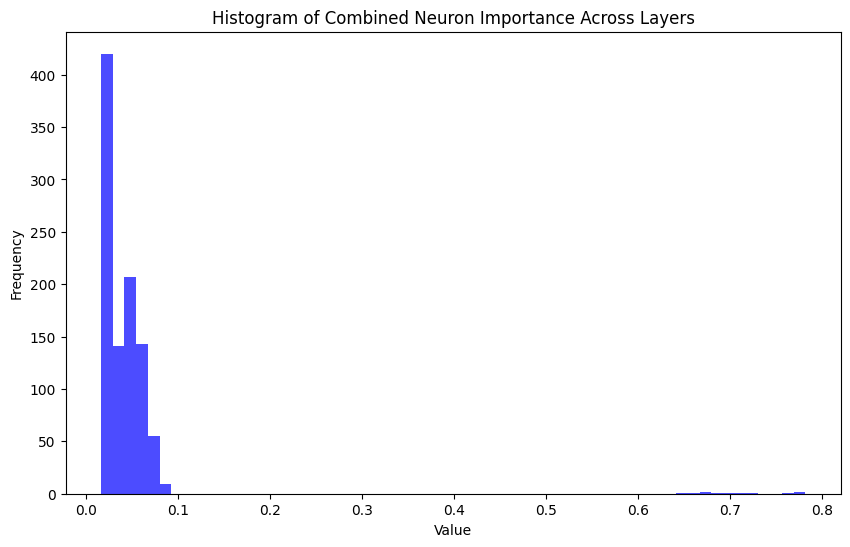

In [7]:
import matplotlib.pyplot as plt

ns = torch.cat((l1, l2, l3, l4))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(ns.detach().numpy(), bins=60, color="blue", alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Neuron Importance Across Layers')

# Show the plot
plt.show()

In [13]:
model.named_parameters

<bound method Module.named_parameters of MNIST_Net(
  (l2): Linear(in_features=784, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)>

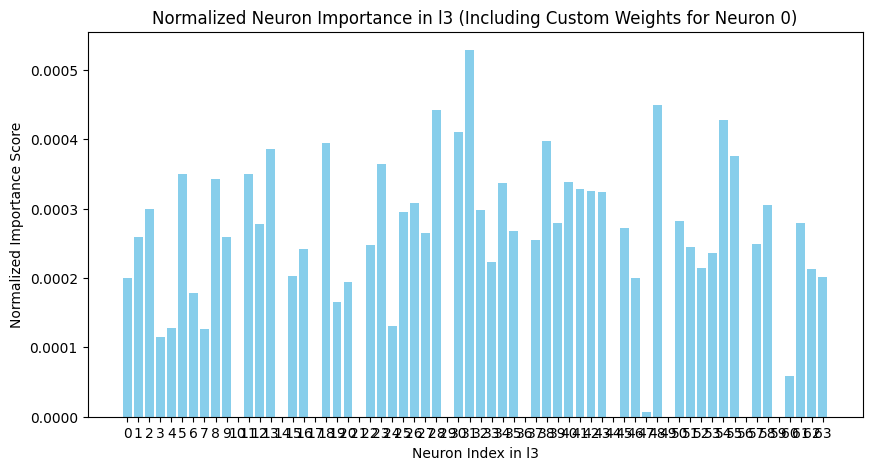

In [21]:
import torch
import matplotlib.pyplot as plt

def compute_neuron_importance(model, data_loader, device):
    model.eval()  # Set model to eval mode

    # Initialize storage for neuron-wise importance scores
    importance_scores = {
        "l2": torch.zeros(model.l2.out_features, device=device),  # 128 neurons
        "l3": torch.zeros(model.l3.out_features, device=device),  # 64 neurons
        "l4": torch.zeros(model.l4.out_features, device=device),  # 10 neurons
    }

    # Number of incoming weights for each neuron (l2 -> l3 and l3 -> l4)
    num_incoming_weights = {
        "l2": model.l2.in_features,  # 784 incoming for each neuron in l2
        "l3": model.l3.in_features,  # 128 incoming for each neuron in l3
        "l4": model.l4.in_features,  # 64 incoming for each neuron in l4
    }

    # Number of custom weights linked to neuron 0 in l3
    custom_weight_count = model.custom_weights.size(0)  # 784 incoming weights for neuron 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        model.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()  # Backpropagate

        # Compute importance per neuron
        if model.l2.weight.grad is not None:
            importance_scores["l2"] += (model.l2.weight.grad.abs() * model.l2.weight.abs()).sum(dim=1)
        if model.l3.weight.grad is not None:
            importance_scores["l3"] += (model.l3.weight.grad.abs() * model.l3.weight.abs()).sum(dim=1)
        if model.l4.weight.grad is not None:
            importance_scores["l4"] += (model.l4.weight.grad.abs() * model.l4.weight.abs()).sum(dim=1)

        # Add contribution from custom weights to neuron 0 in l3
        if model.custom_weights.grad is not None:
            importance_scores["l3"][0] += (model.custom_weights.grad.abs() * model.custom_weights.abs()).sum()

    # Normalize importance scores by the number of incoming weights
    for layer in importance_scores:
        if layer == "l3":
            importance_scores[layer][1:] /= num_incoming_weights[layer]
        else:
            importance_scores[layer] /= num_incoming_weights[layer]

    # Normalize the importance of neuron 0 by considering both standard and custom weights
    importance_scores["l3"][0] /= (num_incoming_weights["l3"] + custom_weight_count)

    # Average importance scores across batches
    for layer in importance_scores:
        importance_scores[layer] /= len(data_loader)

    return importance_scores

# Run the function
neuron_importance = compute_neuron_importance(model, test_loader, device)

# Convert to CPU and detach before plotting
neuron_importance_l3 = neuron_importance["l3"].detach().cpu().numpy()

# Plot neuron importance for l3
plt.figure(figsize=(10, 5))
plt.bar(range(len(neuron_importance_l3)), neuron_importance_l3, color="skyblue")
plt.xlabel("Neuron Index in l3")
plt.ylabel("Normalized Importance Score")
plt.title("Normalized Neuron Importance in l3 (Including Custom Weights for Neuron 0)")
plt.xticks(range(len(neuron_importance_l3)))  # Show all neuron indices
plt.show()


In [22]:
model.l3.weight.abs()

tensor([[0.0716, 0.1155, 0.0751,  ..., 0.0634, 0.0415, 0.1982],
        [0.0399, 0.0755, 0.0815,  ..., 0.0067, 0.0382, 0.0628],
        [0.0787, 0.0615, 0.0523,  ..., 0.0574, 0.0135, 0.0564],
        ...,
        [0.0042, 0.0301, 0.0522,  ..., 0.1793, 0.0054, 0.0590],
        [0.0489, 0.1170, 0.0075,  ..., 0.1121, 0.1221, 0.0457],
        [0.0557, 0.0197, 0.0702,  ..., 0.0803, 0.0184, 0.0275]],
       grad_fn=<AbsBackward0>)

In [23]:
model.l3.weight.grad.abs()

tensor([[0.0000e+00, 6.1548e-07, 0.0000e+00,  ..., 1.0538e-05, 0.0000e+00,
         1.5258e-05],
        [0.0000e+00, 2.3960e-05, 0.0000e+00,  ..., 1.9961e-05, 0.0000e+00,
         2.4563e-03],
        [0.0000e+00, 1.3583e-05, 0.0000e+00,  ..., 7.0992e-07, 0.0000e+00,
         1.2654e-04],
        ...,
        [0.0000e+00, 6.1267e-05, 0.0000e+00,  ..., 3.1434e-06, 0.0000e+00,
         4.3976e-03],
        [0.0000e+00, 1.9179e-04, 0.0000e+00,  ..., 3.7007e-05, 0.0000e+00,
         1.2520e-02],
        [0.0000e+00, 2.1617e-05, 0.0000e+00,  ..., 3.0884e-05, 0.0000e+00,
         4.7778e-03]])

In [8]:
# Print importance for each neuron in l3
for i in range(model.l3.weight.shape[0]):
    importance = (model.l3.weight.grad[i].abs() * model.l3.weight[i].abs()).sum().item()
    print(f"Neuron {i} in l3 importance: {importance}")


TypeError: 'NoneType' object is not subscriptable